In [68]:
%load_ext autoreload
%autoreload 2

from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizerFast
import spacy
import numpy as np
import tqdm
import seaborn as sn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import Ridge
import torch
from rlace import solve_adv_game, init_classifier
import random

en_nlp = spacy.load('en_core_web_sm')


with open("wiki.1million.raw.txt", "r") as f:
    lines = f.readlines()
    sents = [l.strip() for l in lines]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
#tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
#vecs = np.load("encoding-wikipedia_100k_sentence-transformers-all-mpnet-base-v2_none.npy")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vecs = np.load("encoding-wikipedia_100k_bert-base-uncased_none.npy", allow_pickle=True)

def walk_tree(node, depth):
    depths[node.orth_] = depth
    if node.n_lefts + node.n_rights > 0:
        return [walk_tree(child, depth + 1) for child in node.children]




def construct_depth_data(sents, vecs, tokenizer,n=10000):
    
    tokens = []
    mappings = []
    all_depths = []
    
    for i in tqdm.tqdm_notebook(range(n)):
        sent_tokens, mapping = tokenize(sents[i].split(" "), tokenizer)
        tokens.append(sent_tokens)
        mappings.append(mapping)
        
        doc = en_nlp(sents[i])
        depths = []
        for tok in doc:
            depth = 0
            curr = tok
            while not curr.head == curr:
                curr = curr.head
                depth += 1
            depths.append(depth)
        all_depths.append(np.array(depths))
    
    X = []
    ys = []
    for k, (s, sent_depths, sent_tokens, sent_mapping, sent_vecs) in enumerate(zip(sents, all_depths, tokens, mappings, vecs)):
        
        for i, (d,word) in enumerate(zip(sent_depths, s.split(" "))):
            j = sent_mapping[i]
            v = vecs[k][j]
            ys.append(d)
            X.append(v)
    
    return np.array(X), np.array(ys)

def construct_linear_position_data(sents, vecs, tokenizer,n=10000):
    
    tokens = []
    mappings = []
    all_depths = []
    
    for i in tqdm.tqdm_notebook(range(n)):
        sent_tokens, mapping = tokenize(sents[i].split(" "), tokenizer)
        tokens.append(sent_tokens)
        mappings.append(mapping)

    
    X = []
    ys = []
    for k, (s, sent_mapping, sent_tokens, sent_vecs) in enumerate(zip(sents, mappings, tokens, vecs)):
        
        for i, word in enumerate(s.split(" ")):
            j = sent_mapping[i]
            v = vecs[k][j]
            ys.append(j)
            X.append(v)
    
    return np.array(X), np.array(ys)

def construct_len_data(sents, vecs, tokenizer, n=10000, length_in_words=True):
    
    tokens = []
    
    for i in range(n):
        tokens.append(tokenizer.tokenize(sents[i], add_special_tokens=True))
        
    if length_in_words:
        y = np.array([len(s.split(" ")) for s in sents[:n]])
    else:
        y = np.array([len(tks) for tks in tokens])
    X = []
    for i in range(n):
        
        X.append(vecs[i].mean(axis=0))   
    
    return np.array(X),y

def get_regression_P(X,y):
    
    #y = y / np.max(y)
    y = y - y.mean()
    u = X.T@y
    P = np.eye(768) - np.outer(u,u)/np.dot(u,u)
    return P


def tokenize(original_sentence, tokenizer):

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """
        
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        return (bert_tokens, orig_to_tok_map)


def plot_pca(X,y,P,title):
    X,y = X[:5000], y[:5000]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plot = axes[0].scatter(X_pca[:,0], X_pca[:,1], c=y/np.max(y), cmap='GnBu', alpha=0.5)

    X_pca = pca.fit_transform(X@P)
    plot = axes[1].scatter(X_pca[:,0], X_pca[:,1], c=y/np.max(y), cmap='GnBu', alpha=0.5)
    plt.colorbar(plot)
    
    axes[0].set_title("{}: before".format(title))
    axes[1].set_title("{}: After".format(title))
    
    plt.savefig("../WWW/similarity/plots/"+title.replace(" ","_")+".pdf", dpi=500)


In [108]:
X_len.shape,y_len.shape

((50000, 768), (1000000,))

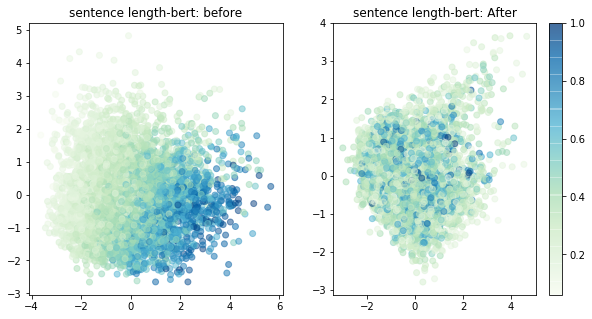

In [116]:
X_len,y_len = construct_len_data(sents, vecs, tokenizer, n=50000)
P_len = get_regression_P(X_len,y_len)
np.save("../WWW/similarity/projs/P_length_bert.npy", P_len)
plot_pca(X_len,y_len,P_len,"sentence length-bert")
y_len_bins = []
for y in y_len:
    if y <= 5:
        y_len_bins.append(0)
    elif 5 < y <= 10:
        y_len_bins.append(1)
    elif 10 < y <= 15:
        y_len_bins.append(2)
    elif 15 < y <= 20:
        y_len_bins.append(3)
    elif 20 < y <= 25:
        y_len_bins.append(4)
    elif 25 < y <= 30:
        y_len_bins.append(5)
    else:
        y_len_bins.append(6)
        
y_len_bins = np.array(y_len_bins)

In [131]:
Counter(y_depth)

Counter({1: 19188,
         0: 4116,
         2: 18001,
         3: 14391,
         4: 10106,
         5: 6598,
         6: 3900,
         8: 1287,
         7: 2314,
         9: 700,
         10: 379,
         12: 111,
         11: 208,
         13: 75,
         14: 34,
         15: 15,
         16: 5,
         18: 1,
         17: 4})

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/4000 [00:00<?, ?it/s]

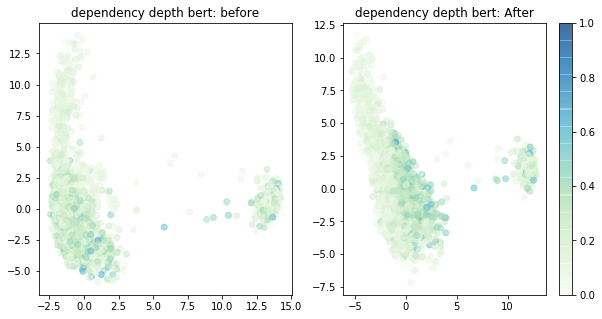

In [133]:
X_depth,y_depth = construct_depth_data(sents, vecs, tokenizer,n=4000)
P_depth = get_regression_P(X_depth,y_depth)
np.save("../WWW/similarity/projs/P_depth_bert.npy", P_depth)
plot_pca(X_depth,y_depth,P_depth,"dependency depth bert")

y_depth_bins = []
for y in y_depth:
    if y <= 8:
        y_depth_bins.append(y)
    else:
        y_depth_bins.append(9)
        
y_depth_bins = np.array(y_depth_bins)

In [89]:
y_depth_normalized = y_depth/np.max(y_depth)
y_depth_normalized = y_depth_normalized - y_depth_normalized.mean()

regression_model = Ridge()
regression_model.fit(X_depth, y_depth_normalized)
regression_model.score(X_depth, y_depth_normalized)

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.95614e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


0.4900831753569417

In [86]:
X_position.shape

(81433, 768)

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5000 [00:00<?, ?it/s]

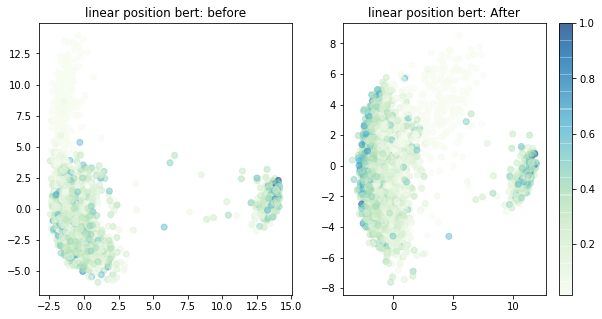

In [93]:
X_position,y_position = construct_linear_position_data(sents, vecs, tokenizer,n=5000)
P_position = get_regression_P(X_position,y_position)
np.save("../WWW/similarity/projs/P_position_bert.npy", P_position)
plot_pca(X_position,y_position,P_position,"linear position bert")

In [94]:
X_position.shape

(102216, 768)

In [95]:
y_position_normalized = y_position/np.max(y_position)
y_position_normalized = y_position_normalized - y_position_normalized.mean()

In [96]:
regression_model = Ridge()
regression_model.fit(X_position, y_position_normalized)
regression_model.score(X_position, y_position_normalized)

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.17844e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


0.7077986336915285

In [30]:
regression_model = Ridge()
regression_model.fit(X_len, y_len)
regression_model.score(X_len, y_len)

0.8794869659668467

In [32]:
regression_model = Ridge()
regression_model.fit(X_position, y_position)
regression_model.score(X_position, y_position)

0.6194631860578753

## RLACE

In [127]:
num_iters = 60000
rank=5
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.005, "weight_decay": 1e-5, "momentum":0.5}
optimizer_params_predictor = {"lr": 0.005,"weight_decay": 1e-5, "momentum": 0.5}
epsilon = 0.00075 # stop 0.1% from majority acc
batch_size = 256

random.seed(0)
np.random.seed(0)

In [128]:
output = solve_adv_game(X_len[:50000], y_len_bins[:50000], X_len[:50000], y_len_bins[:50000], rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)

59000/60000. Acc post-projection: 28.204%; best so-far: 22.924%; Maj: 22.558%; Gap: 0.366%; best loss so far: 1.766: 100%|##########| 60000/60000 [1:08:18<00:00, 14.64it/s]  


In [130]:
np.save("../WWW/similarity/projs/P_length_clf_bert.npy", output["P"])

In [ ]:
output = solve_adv_game(X_depth[:50000], y_depth_bins[:50000], X_depth[:50000], y_depth_bins[:50000], rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)

0/60000. Acc post-projection: 44.870%; best so-far: 44.870%; Maj: 23.458%; Gap: 21.412%; best loss so far: 1.452:   2%|1         | 1000/60000 [01:37<32:56, 29.86it/s]  

In [ ]:
np.save("../WWW/similarity/projs/P_depth_clf_bert.npy", output["P"])

In [261]:
for tok in doc:
    depth = 0
    curr = tok
    while not curr.head == curr:
        curr = curr.head
        depth += 1
    print(tok, depth)

That 1
was 0
the 2
second 3
largest 2
increase 1
in 2
the 4
country 3
, 1
and 1
presently 2
Georgia 2
is 1
the 3
sixth 3
fastest 3
growing 3
state 2
in 3
the 5
United 5
States 4
. 2


In [259]:
tok

was

In [256]:
tok.head.head.head.head

was

In [1]:
X_depth.shape

NameError: name 'X_depth' is not defined